In [3]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations
using Plots

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");
pyplot()

Plots.PyPlotBackend()

In [18]:
function read_fish(filename::String)
    data,header = readdlm(filename,',',header = true)
    header = header[:]
    if "year" in header
        @info "Working on a temporal data file"
        stationname = Vector{String}(data[:,findfirst(header .== "samp")]);
        obsyear = Vector{Int32}(data[:,findfirst(header .== "year")]);
    else
        @info "Working on a spatial data file"
        obsyear = undef;
    end;
    
    obslon = Vector{Float64}(data[:,findfirst(header .== "x")]);
    obslat = Vector{Float64}(data[:,findfirst(header .== "y")]);

    g1 = Vector{Float64}(data[:,findfirst(header .== "g1")]);
    g2 = Vector{Float64}(data[:,findfirst(header .== "g2")]);
    g3 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    g4 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    
    @info "Number of data points: $(length(g1))"
    
    return obslon, obslat, obsyear, g1, g2, g3, g4
end

read_fish (generic function with 1 method)

In [19]:
fishdatadir = "/home/ctroupin/tmp/Emodnet-Bio/Olivier-Fish/"
datafileS = joinpath(fishdatadir, "Fish_spa_abs.csv");
datafileT = joinpath(fishdatadir, "Fish_temp_abs.csv");

## Data reading
We use the function `read_fish` define in the module `make_benthos_products.jl`.

In [44]:
@time obslonT, obslatT, obsyearT, g1T, g2T, g3T, g4T = read_fish(datafileT);
@time obslonS, obslatS, obsyearS, g1S, g2S, g3S, g4S = read_fish(datafileS);
@info extrema(obslonS)
@info extrema(obslatS)

  0.886363 seconds (8.21 M allocations: 201.689 MiB, 4.20% gc time)


┌ Info: Working on a temporal data file
└ @ Main In[18]:5
┌ Info: Number of data points: 37595
└ @ Main In[18]:26


  0.581824 seconds (5.44 M allocations: 135.215 MiB, 3.19% gc time)


┌ Info: Working on a spatial data file
└ @ Main In[18]:9
┌ Info: Number of data points: 37739
└ @ Main In[18]:26
┌ Info: (-15.9157, 22.2)
└ @ Main In[44]:3
┌ Info: (36.0013, 61.8833)
└ @ Main In[44]:4


### Mask and metrics

In [53]:
xi,yi = DIVAnd.ndgrid(gridlonFish, gridlatFish);
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

#### Extract the mask from the bathymetry

In [46]:
gridlonFish = -16 : dlon : 23
gridlatFish = 36 : dlat :  62
topodir = "/home/ctroupin/Projects/Diva-Workshops/notebooks/data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonFish, gridlatFish);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonFish, gridlatFish,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

┌ Info: (391, 261)
└ @ Main In[46]:13


#### Plot mask

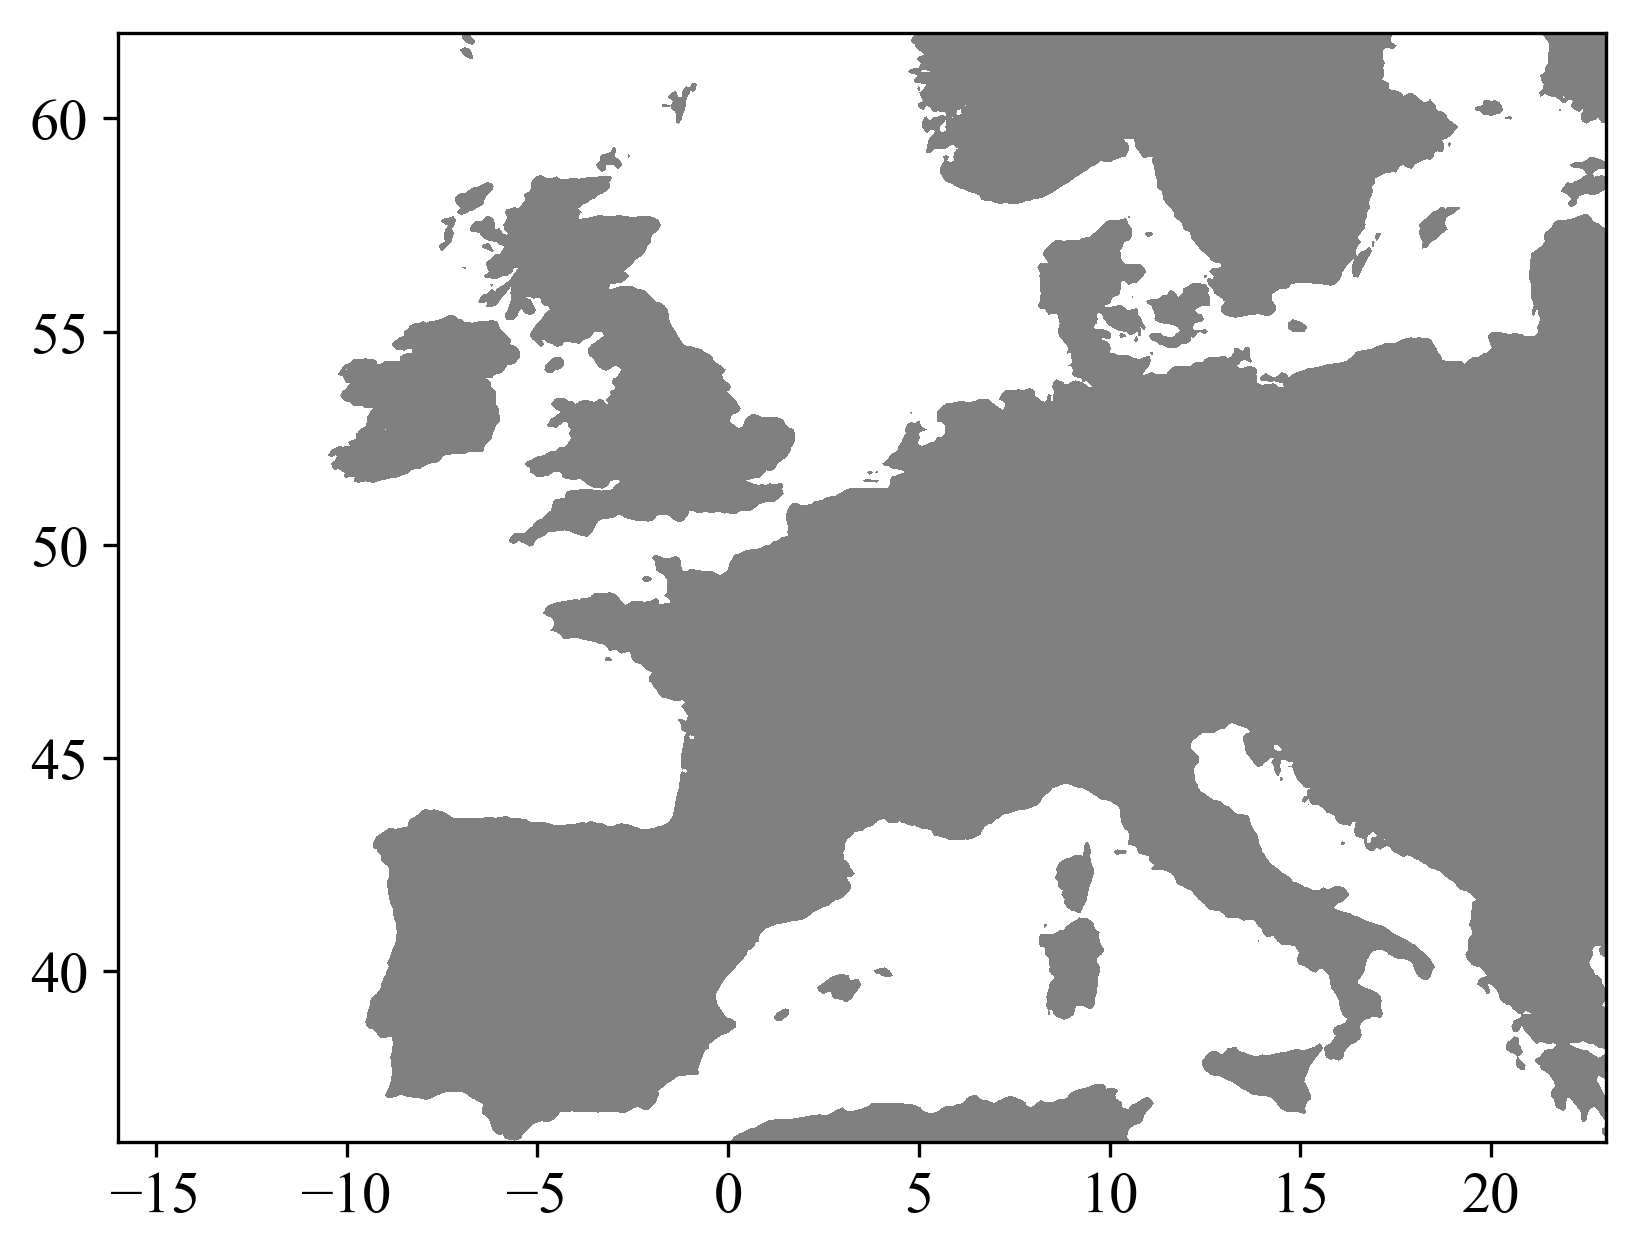

PyObject <matplotlib.contour.QuadContourSet object at 0x7ff15f780f60>

In [48]:
function add_mask(bx, by, b)
    PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0], colors = [[.5,.5,.5]])
end
add_mask(bx, by, b)

### Plot the data values

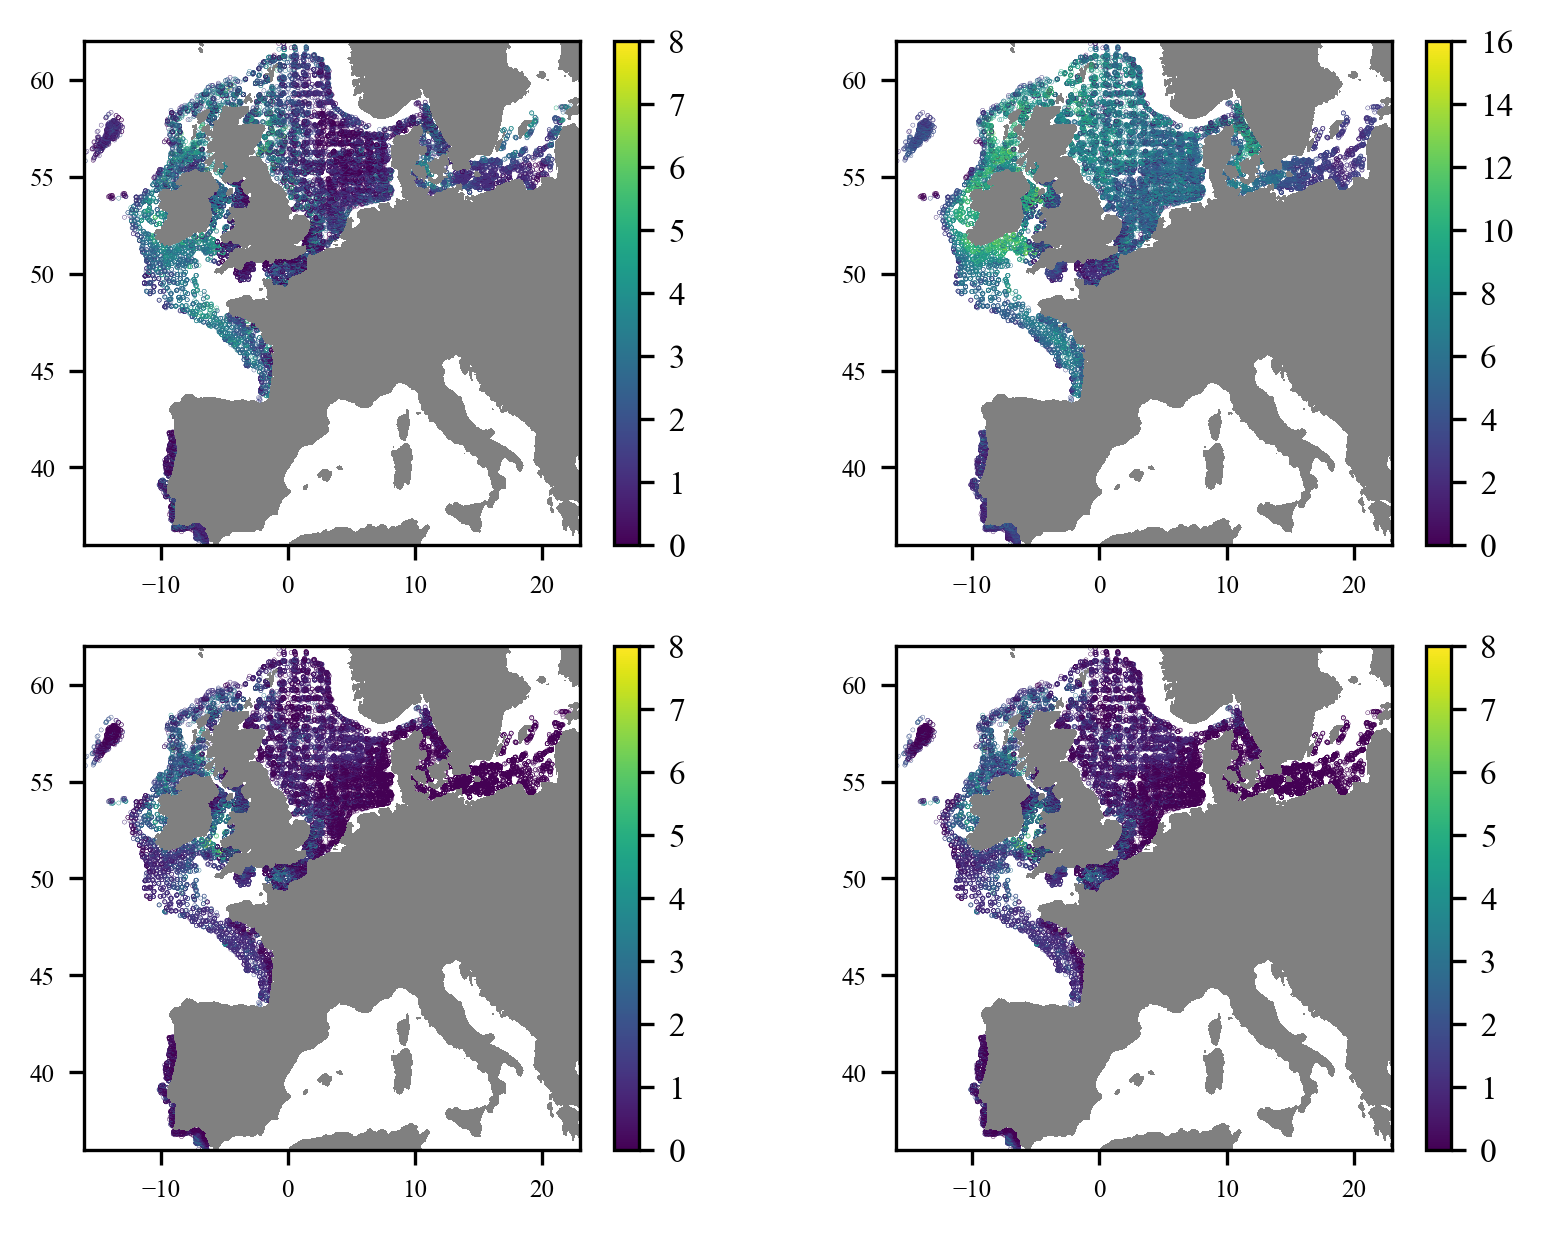

In [52]:
figure()
ax1 = subplot(2,2,1)
ax1[:tick_params]("both",labelsize=6)
scat1 = PyPlot.scatter(obslonS, obslatS, s=.01, c=g1S)
add_mask(bx, by, b)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
colorbar(scat1)[:ax][:tick_params](labelsize=8)
ax2 = subplot(2,2,2)
ax2[:tick_params]("both",labelsize=6)
scat2 = PyPlot.scatter(obslonS, obslatS, s=.01, c=g2S)
add_mask(bx, by, b)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
colorbar(scat2)[:ax][:tick_params](labelsize=8)
ax3 = subplot(2,2,3)
ax3[:tick_params]("both",labelsize=6)
scat3 = PyPlot.scatter(obslonS, obslatS, s=.01, c=g3S)
add_mask(bx, by, b)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
colorbar(scat3)[:ax][:tick_params](labelsize=8)
ax4 = subplot(2,2,4)
ax4[:tick_params]("both",labelsize=6)
scat4 = PyPlot.scatter(obslonS, obslatS, s=.01, c=g4S)
add_mask(bx, by, b)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
colorbar(scat4)[:ax][:tick_params](labelsize=8)

## Spatial analysis
All the data are considered simultaneously, i.e. the year of measurement is not taken into account.      
We first transform the data.

In [41]:
g1log = log.(g1S .+ 1);
g2log = log.(g2S .+ 1);
g3log = log.(g3S .+ 1);
g4log = log.(g4S .+ 1);

### Parameter determination
#### Correlation length

In [42]:
distbin = 0:.5:7.5;
mincount = 100;
var0,lenHori1,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g1log .- mean(g1log),distbin,mincount);
var0,lenHori2,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g2log .- mean(g2log),distbin,mincount);
var0,lenHori3,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g3log .- mean(g3log),distbin,mincount);
var0,lenHori4,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g4log .- mean(g4log),distbin,mincount);
@show lenHori1, lenHori2, lenHori3, lenHori4

(lenHori1, lenHori2, lenHori3, lenHori4) = (2.149222772277228, 1.4581543564356436, 3.54536099009901, 3.558362277227723)


(2.149222772277228, 1.4581543564356436, 3.54536099009901, 3.558362277227723)

#### Data weights
The weight is decreased for very close points.

In [43]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslonS,obslatS),(0.03,0.03))
@show maximum(rdiag),mean(rdiag)

(maximum(rdiag), mean(rdiag)) = (34.37624664581307, 7.5999287214601505)


(34.37624664581307, 7.5999287214601505)

#### Signal-to-noise ratio
We use the cross-validation tool for each of the 4 variables.

In [54]:
epsilon2 = 0.02;
bestfactorl1,bestfactore1, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = 
DIVAnd_cv(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),g1log .- mean(g1log),lenHori1,epsilon2*rdiag,2,3);
@show bestfactorl1, bestfactore1

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = localize_separable_grid(::Tuple{Array{Float64,1},Array{Float64,1}}, ::BitArray{2}, ::Tuple{Array{Float64,2},Array{Float64,2}}) at localize_separable_grid.jl:47
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/jGvNn/src/localize_separable_grid.jl:47
┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = localize_separable_grid(::Tuple{Array{Float64,1},Array{Float64,1}}, ::BitArray{2}, ::Tuple{Array{Float64,2},Array{Float64,2}}) at localize_separable_grid.jl:47
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/jGvNn/src/localize_separable_grid.jl:47


(bestfactorl1, bestfactore1) = (0.07943282347242814, 0.3764560540428128)


(0.07943282347242814, 0.3764560540428128)

In [55]:
epsilon2new = epsilon2 * bestfactore1

0.007529121080856256

In [56]:
lenHori1new = lenHori1 * bestfactorl1

0.17071883307321967

## Perform interpolation

In [57]:
@time 🐟1,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslonS,obslatS), g1log .- mean(g1log),lenHori1new,epsilon2new,alphabc=2);

 14.572106 seconds (11.84 M allocations: 1.964 GiB, 3.39% gc time)


In [68]:
write_fish_nc("Fish1.nc", gridlonFish, gridlatFish, 🐟1,🐟1,🐟1,🐟1,🐟1,🐟1,🐟1,🐟1);

In [67]:
function write_fish_nc(filename::String, gridlon, gridlat,
        field1::Array, field2::Array, field3::Array, field4::Array,
        err1::Array, err2::Array, err3::Array, err4::Array)

    Dataset(filename,"c") do ds

        nlon = length(gridlon);
        nlat = length(gridlat);

        # Define the dimension "lon" and "lat" with the size 100 and 110 resp.
        defDim(ds,"lon",nlon);
        defDim(ds,"lat",nlat);

        # Define a global attribute
        ds.attrib["title"] = "Interpolated Fish"

        # Define the variables and coordinates
        lon = defVar(ds,"lon",Float32,("lon",))
        lat = defVar(ds,"lat",Float32,("lat",))

        # Interpolated fields
        g1 = defVar(ds,"g1",Float64,("lon","lat"))
        g2 = defVar(ds,"g2",Float64,("lon","lat"))
        g3 = defVar(ds,"g3",Float64,("lon","lat"))

        # Error fields
        g1_err = defVar(ds,"g1_err",Float64,("lon","lat"))
        g2_err = defVar(ds,"g2_err",Float64,("lon","lat"))
        g3_err = defVar(ds,"g3_err",Float64,("lon","lat"))


        # Fill the coord vectors and the fields
        lon[:] = gridlon;
        lat[:] = gridlat;

        g1[:,:] = field1;
       # g2[:,:] = field2;
       # g3[:,:] = field3;
       # g4[:,:] = field4;

       # g1_err[:,:] = err1;
       # g2_err[:,:] = err2;
       # g3_err[:,:] = err3;
       # g4_err[:,:] = err4;

    end
end;